<a href="https://colab.research.google.com/github/costayca/GroceryCNN/blob/main/GroceryCNN-5cat-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
#import required libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [4]:
#import model

## Resnet
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

## NasNetLarge
#from tensorflow.keras.applications.nasnet import NASNetLarge
#from tensorflow.keras.applications.nasnet import preprocess_input, decode_predictions

## NasNetMobile
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input, decode_predictions


In [5]:
%cd /content/drive/MyDrive/Licenta/28.12.2020/

/content/drive/MyDrive/Licenta/28.12.2020


In [64]:
#image data generator

# Image data Generator parameters
#                                     width_shift_range=[-100,100],
#                                    height_shift_range=[-100,100],
#                                    horizontal_flip=True,
#                                    vertical_flip=True,
#                                    rotation_range=90,
#                                    brightness_range=[0.6,1.0],
#                                    zoom_range=[0.9,1.0]
train_datagen = ImageDataGenerator(
                                   preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory("dataset_5_cat/train",
                                                    target_size=(224,224),
                                                    color_mode="rgb",
                                                    batch_size=4,
                                                    class_mode="categorical")

Found 254 images belonging to 5 classes.


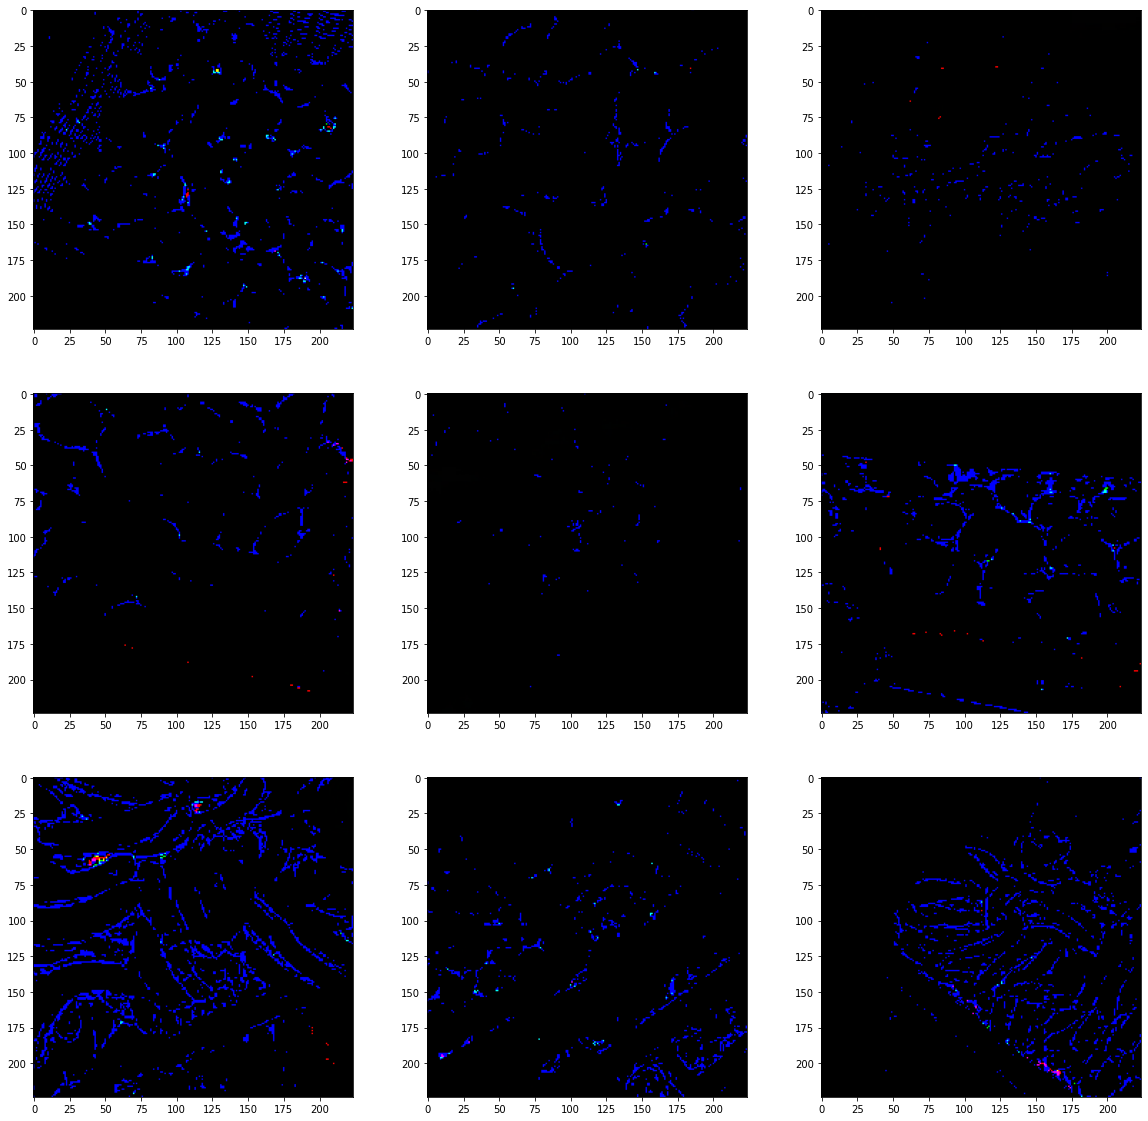

In [63]:
# image generator test

from matplotlib import pyplot

pyplot.figure(figsize=(20, 20))

# generate samples and plot
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = train_generator.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    pyplot.imshow(image.squeeze())
 
 # show the figure
pyplot.show()

In [65]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_generator = valid_datagen.flow_from_directory("dataset_5_cat/val",
                                                    target_size=(224,224),
                                                    color_mode="rgb",
                                                    batch_size=4,
                                                    class_mode="categorical")

Found 78 images belonging to 5 classes.


## Transfer Learning

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [8]:
base_model = NASNetMobile(include_top=False, input_shape=(224,224,3))

19996672/19993432 [==============================] - 0s 0us/step


In [9]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [10]:
model_tl = Sequential()

model_tl.add(base_model)
model_tl.add(Flatten())
model_tl.add(Dense(5, activation="softmax"))

In [11]:
model_tl.layers[0].trainable = False

In [12]:
model_tl.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
flatten (Flatten)            (None, 51744)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 258725    
Total params: 4,528,441
Trainable params: 258,725
Non-trainable params: 4,269,716
_________________________________________________________________


In [13]:
# compiling
model_tl.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [51]:
# Create a checkpoint
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = "/content/drive/MyDrive/Licenta/28.12.2020/checkpoints/save_model.hdf5"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                            monitor="accuracy", 
                                            save_best_only=True, 
                                            verbose=1,
                                            mode='auto',
                                            save_freq='epoch')

In [66]:
fit_history = model_tl.fit(train_generator, validation_data=valid_generator, epochs=5, callbacks=[model_checkpoint_callback])

Epoch 1/5
64/64 [==============================] - 40s 620ms/step - loss: 8.7436 - accuracy: 0.7953 - val_loss: 0.9216 - val_accuracy: 0.9615

Epoch 00001: accuracy improved from 0.50787 to 0.79528, saving model to /content/drive/MyDrive/Licenta/28.12.2020/checkpoints/save_model.hdf5
Epoch 2/5
64/64 [==============================] - 40s 627ms/step - loss: 0.2185 - accuracy: 0.9921 - val_loss: 1.8901 - val_accuracy: 0.9487

Epoch 00002: accuracy improved from 0.79528 to 0.99213, saving model to /content/drive/MyDrive/Licenta/28.12.2020/checkpoints/save_model.hdf5
Epoch 3/5
64/64 [==============================] - 40s 622ms/step - loss: 7.2497e-05 - accuracy: 1.0000 - val_loss: 1.7990 - val_accuracy: 0.9487

Epoch 00003: accuracy improved from 0.99213 to 1.00000, saving model to /content/drive/MyDrive/Licenta/28.12.2020/checkpoints/save_model.hdf5
Epoch 4/5
64/64 [==============================] - 40s 623ms/step - loss: 4.6933e-10 - accuracy: 1.0000 - val_loss: 1.7980 - val_accuracy: 0.

In [67]:
model_tl.load_weights(checkpoint_filepath)

## Test the model

In [68]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory("dataset_5_cat/test",
                                                    target_size=(224,224),
                                                    color_mode="rgb",
                                                    batch_size=1,
                                                    class_mode="categorical",
                                                    shuffle=False)

Found 25 images belonging to 5 classes.


### Visualize predictions

In [69]:
test_generator.reset()

pred = model_tl.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

 1/25 [>.............................] - ETA: 3s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


25/25 [==============================] - 3s 128ms/step


In [70]:
predicted_class_indices = np.argmax(pred, axis = 1)

In [19]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

In [20]:
read = lambda image_name: np.asarray(load_img(image_name, target_size=(224, 224)))

def plot_image(base_path, images, image_count, labels, image_width=18, image_height=12):
    fig=plt.figure(figsize=(image_width, image_height))
    
    columns = 10
    rows = image_count // columns

    for i in range(1, columns*rows + 1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(labels[i])
        img = read(os.path.join(base_path, images[i]))
        plt.imshow(img, interpolation='nearest')

In [80]:
labelList = os.listdir("dataset_5_cat/train")

labelList.sort()

print(predicted_class_indices)
print(labelList)

labels = [labelList[i] for i in predicted_class_indices]

[0 0 0 0 0 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4]
['Asparagus', 'Aubergine', 'Avocado', 'Banana', 'Brown-Cap-Mushroom']


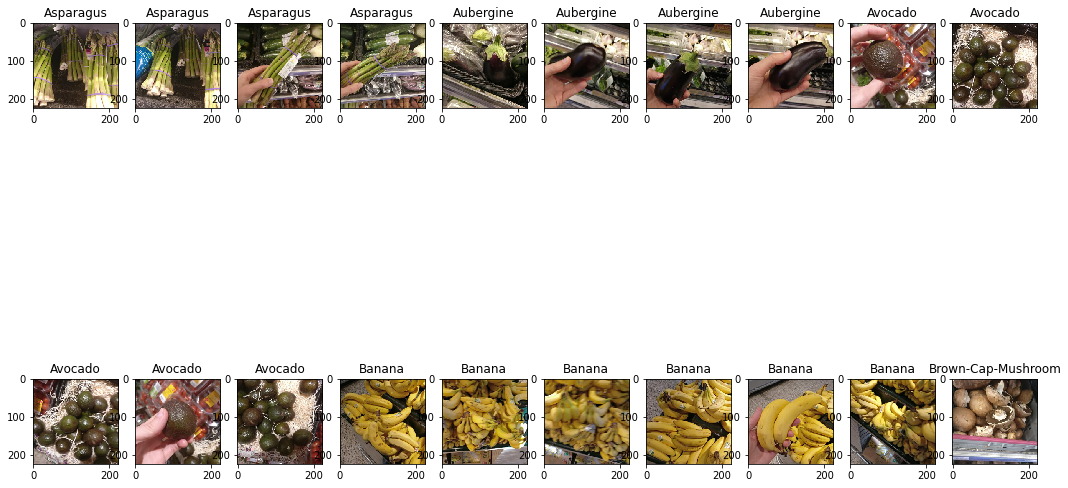

In [81]:
plot_image("dataset_5_cat/test", test_generator.filenames, 25, labels)